# Well balanced second order MUSCL Scheme for the Shallow Water Equations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## MUSCL reconstruction 
Using $U=(h,hu)$ the first reconstruction consists of
* Obtain reconstructed values of conserved variables $U_{i,r},U_{i,l}$ 
* Reconstruct free surface elevation $H_{i,l}$ and $H_{i,r}$ where $H=h+d$
* Obtain topography values $d_{i,l}$ and $d_{i,r}$, where $d=H-h$, con $H$ y $h$ from the reconstruction


In [2]:
%%writefile nswe_wbmuscl2.py 

import numpy as np
g = 9.81

def roe(hl,ul,hr,ur,i=None,kappa=1e-4):
    """
        El solver de roe del paper de Marche (2006?)
    """
    if np.isnan(hl) or np.isnan(hr):
        if not i : 
            print hl,hr
        else:
            print i,hl,hr,'nan'
            
    if hl<kappa and hr < kappa:
        return 0.0, 0.0

    wl1 = ul - 2*np.sqrt(g*hl)
    wl2 = ul + 2*np.sqrt(g*hl)

    wr1 = ur - 2*np.sqrt(g*hr)
    wr2 = ur + 2*np.sqrt(g*hr)

    uhat = 0.5*(ul+ur)
    hhat = 0.25*(np.sqrt(hl) + np.sqrt(hr))**2

    l1 = uhat - np.sqrt(g*hhat)
    l2 = uhat + np.sqrt(g*hhat)
    l1l = ul - np.sqrt(g*hl)
    l2l = ul + np.sqrt(g*hl)
    l1r = ur - np.sqrt(g*hr)
    l2r = ur + np.sqrt(g*hr)    
  
    #entropy fix programado en el surfwb-uc
    if l1>0:
        ws1 = wl1
        ws2 = wl2
    else:
        ws1 = wr1        
        if l2>0:
            ws2 = wl2
        else:
            ws2 = wr2

    us = 0.5*(ws1+ws2)
    hs = (ws2-ws1)**2/(16.*g)
    
    #entropy fix de marche
    if l1l<0 and l1r > 0:
        us = uhat
        hs = hhat
        
    if l2l<0 and l2r > 0:
        us = uhat
        hs = hhat
    if np.sqrt(hs*g) <= kappa:
        hs = kappa
        us = 0.0        
    return hs,us

Overwriting nswe_wbmuscl2.py


In [3]:
%%writefile nswe_wbmuscl2.py -a

def minmod(slope1, slope2):
    if (slope1>0 and slope2 > 0):
        return min(slope1,slope2)
    if (slope1<0 and slope2<0):
        return max(slope1,slope2)
    return 0.
minmod = np.vectorize(minmod)

Appending to nswe_wbmuscl2.py


In [4]:
%%writefile nswe_wbmuscl2.py -a

def musclReconstr(ul,uc,ur,dx):
    slopeb = (uc-ul)/dx
    slopef = (ur-uc)/dx
    slope = minmod(slopeb,slopef)
    uil = uc - 0.5*dx*slope
    uir = uc + 0.5*dx*slope
    
    return uil, uir

Appending to nswe_wbmuscl2.py


In [5]:
%%writefile nswe_wbmuscl2.py -a

def allMusclReconstr(Ul,Uc,Ur,dl,dc,dr,dx=1,hmin=1e-10):
    """
        Receives states U=(h,hu) and topography d, from a cell (say 1) 
        and its first neighbors (0 and 2) 
        and returns muscl reconstruction U_{il} and U_{ir} and
        d_{il}, d_{ir} of conserved variables and bathymetry at
        cell boundaries
        
        U0,U1,U2,d0,d1,d2 are 
        
        dx is irrelevant for regular grids
        but is kept for code semantic and mantainability
    """
      
    #primitive variables 
    Uil, Uir = musclReconstr(Ul,Uc,Ur,dx)
#     hil, hir = musclReconstr(hl,hc,hr,dx)
#     uil, uir = musclReconstr(ul,uc,ur,dx)
    
    
    #free surface H
    Hl = Ul[0] + dl
    Hc = Uc[0] + dc
    Hr = Ur[0] + dr
    
    Hil, Hir = musclReconstr(Hl, Hc, Hr, dx)

    #topography d
    d_il = Hil - Uil[0]
    d_ir = Hir - Uir[0]

    return d_il, d_ir , Uil, Uir

Appending to nswe_wbmuscl2.py


In [6]:
%%writefile nswe_wbmuscl2.py -a


def getMusclReconstr(d,hn,un):
    """
    Receives d (1,nx+4) and h,u (1,nx+4)
    and returns dl,dr,ul,ur (1\times nx+2)
    for innercells + 1ghost at each end
    
    0, [1, (2, ... , nx, nx+1), nx+2], nx+3
    
    that is, for cells 1 to nx+2 = range(1,nx+3)
    """
    nx = d.shape[0]-4
    dl = np.zeros((nx+2,))
    dr = np.zeros((nx+2,))
    hl = np.zeros((nx+2,))
    hr = np.zeros((nx+2,))
    ul = np.zeros((nx+2,))
    ur = np.zeros((nx+2,))
    for i in range(1,nx+3,1):
        u0 = np.array([hn[i-1],un[i-1]])
        
        u1 = np.array([hn[i],un[i]])
        
        u2 = np.array([hn[i+1],un[i+1]])
        
        d0 = d[i-1]
        d1 = d[i]
        d2 = d[i+1]
        
        
#         return d_il, d_ir , Uil, Uir
        dl[i-1], dr[i-1], (hl[i-1],ul[i-1]), (hr[i-1],ur[i-1]) = allMusclReconstr(u0,u1,u2,d0,d1,d2)
    #
    return dl, dr, hl, hr, ul, ur        

Appending to nswe_wbmuscl2.py


## Hydrostatic reconstruction
* Interface topography values are defined as $$d_{i+1/2} = max(d_{i,r}, d_{i+1,l})$$
* And water height at each side of interfaces as

$$h_{i+1/2-} = max(0, h_{i,r} +d_{i,r} - d_{i+1/2})$$
  $$h_{i+1/2+} = max(0, h_{i+1,l}+d_{i+1,l}-d_{i+1/2})$$
  
* Finally, conserved values at each side of the interface

$$ U_{i+1/2-} = (h_{i+1/2-}, h_{i+1/2-} u_{i,r})^t$$
$$ U_{i+1/2+} = (h_{i+1/2+}, h_{i+1/2+} u_{i+1,l})^t$$

In [7]:
%%writefile nswe_wbmuscl2.py -a


#recibe dl,dr,hl,hr,hul,hur (nx-2, sigo el ejemplo de arriba)
#entrega valores plus minus de la reconstruccion hidrostatica

def getHydrReconstr(dl,dr,hl,hr,ul,ur):
    """
        Receives values d_il, d_ir, h_il, h_ir, etc,
        in arrays dl,dr,hl,hr,ul,ur of size (nx+2) 
        (nx + 2 ghost cells)
        and calculates the hydrostatic reconstruction
        for h_{i+1/2^+} and h_{i+1/2-} for i from
        1 to nx+1.
        
        0, 1,(2, ..., nx, nx+1), nx+2, nx+3
    """
    nx = dl.shape[0]-2
    dinter = np.zeros((nx+1,))
    hp = np.zeros((nx+1,))
    up = np.zeros((nx+1,))
    hm = np.zeros((nx+1,))
    um = np.zeros((nx+1,))

    dinter = np.maximum(dr[:-1],dl[1:])
    hm = np.maximum(0., hr[:-1]+dr[:-1]-dinter)
    hp = np.maximum(0., hl[1:]+dl[1:]-dinter)
#     hum = np.where(hr[:-1]>0,hm*hur[:-1]/hr[:-1],0.)
#     hup = np.where(hl[1:]>0,hp*hul[1:]/hl[1:],0.)
    um = ur[:-1]
    up = ul[1:]
    return dinter, hm, hp, um, up

Appending to nswe_wbmuscl2.py


## Sources and interface fluxes

The interface fluxes are calculated as

$$F_{i+1/2}^- = F^*_{i+1/2} + S_{i+1/2-}$$
$$F_{i+1/2}^+ = F^*_{i+1/2} + S_{i+1/2+}$$

where $$F^*_{i+1/2} = \mathcal{F}(U^*_{i+1/2}(0, U_{i+1/2-}, U_{i+1/2+})$$ with $U^*(t,U_l,U_r)$ is the operator that solves the homogeneous Riemann problem for a given $t$ between states $U_l$ and $U_r$ and $\mathcal{F}(U)$ is the interface flux function

additionally

$$S_{i+1/2-} = \left(0, \frac{g}{2}(h_{i+1/2-}^2 -h_{i,r}^2)\right)^t$$
$$S_{i-1/2+} = \left(0, \frac{g}{2}(h_{i,l}^2 -h_{i-1/2+}^2)\right)^t$$

or better using $i+1/2\pm$
$$S_{i+1/2+} = \left(0, \frac{g}{2}(h_{i+1,l}^2 -h_{i+1/2+}^2)\right)^t$$
$$S_{i+1/2-} = \left(0, \frac{g}{2}(h_{i+1/2-}^2 -h_{i,r}^2)\right)^t$$

Given these definitions the semidiscrete system is

$$ \Delta x \frac{d}{dt} U_{i}(t) + (F_{i+1/2}^- - F_{i-1/2}^+) = S_{c,i}$$

where $$S_{c,i} = \left( 0, g\frac{h_{i,l}+h_{i,r}}{2}(d_{i,l}-d_{i,r}) \right)^T $$

In [8]:
%%writefile nswe_wbmuscl2.py -a


def sources(dl,dr,hl,hr,hp,hm):
    sp = np.zeros((2,hl[1:].shape[0]))
    sm = np.zeros((2,hm.shape[0]))
    sc = np.zeros((2,dl.shape[0]))
    sp[1,:] = 0.5*g*(hl[1:]**2-hp**2) #S_{i+1/2+}   
    sm[1,:] = 0.5*g*(-hm**2+hr[:-1]**2)    #S_{i+1/2-}
    sc[1,:] = 0.5*g*(hl+hr)*(dl-dr) #S_{c,i}
    return sp, sm, sc

Appending to nswe_wbmuscl2.py


In [9]:
%%writefile nswe_wbmuscl2.py -a


def flux(h,u):
    out = np.array([h*u, 0.5*g*h**2 + h*u**2])
    return out

Appending to nswe_wbmuscl2.py


In [10]:
%%writefile nswe_wbmuscl2.py -a

def fluxes_sources(d,hn,un,hmin=1e-10):
    """
        Calcula los flujos en cada interfaz,
        Tambien entrega el termino fuente centrado
        de la reconstruccion hidrostatica
        Retorna:
        
        fp: F_{i+1/2^+} de 2xninterfaces=2x(nx+1)
        fm: F_{i+1/2^-} de 2xninterfaces=2x(nx+1)
        sc: 
        ninterfaces = nx+1: (indice 0), desde 1+1/2...nx+1/2
        
    """
    nx = d.shape[0]-4
    fs = np.zeros((2,nx+1))
    fp = np.zeros((2,nx+1))
    fm = np.zeros((2,nx+1))
    
    dl, dr, hl, hr, ul, ur = getMusclReconstr(d,hn,un)
    
    dinter, hm, hp, um, up = getHydrReconstr(dl,dr,hl,hr,ul,ur)
    sp, sm, sc = sources(dl,dr,hl,hr,hp,hm)
    
    #ahora calcular los flujos estrella
    for i in range(nx+1):        
        hs,us = roe(hm[i],um[i],hp[i],up[i],kappa=hmin)
        fs[:,i] = flux(hs,us)
        
    #calculate fp and fm
    fp = fs + sp
    fm = fs + sm
    
    return fp, fm, sc

Appending to nswe_wbmuscl2.py


For debugging

# Boundary conditions

In [11]:
%%writefile -a nswe_wbmuscl2.py

def bcs_open(d,h0,hu0,*args):
    """ 
        recibe las matrices y coloca los valores 
        correspondientes a la celda cerrada.
        
        Este es el tipico borde cerrado.
        
        No estoy seguro
        si modificar h,hu aqui dentro
        hace que se modifique fuera,
        asi que uso hb,hub
    """
    db = 1.*d
    hb = 1.*h0
    hub = 1.*hu0
    db[0] = db[3]
    db[1] = db[2]
    hb[0] = hb[3]
    hb[1] = hb[2]
    hub[0] = hub[3]
    hub[1] = hub[2]
    
    db[-1] = db[-4]
    db[-2] = db[-3]
    hb[-1] = hb[-4]
    hb[-2] = hb[-3]
    hub[-1] = hub[-4]    
    hub[-2] = hub[-3]    
    return db,hb,hub

Appending to nswe_wbmuscl2.py


In [12]:
%%writefile nswe_wbmuscl2.py -a

def bcs_cerrado(d,h0,hu0,*args):
    """ 
        recibe las matrices y coloca los valores 
        correspondientes a la celda cerrada.
        
        Este es el tipico borde cerrado.
        
        No estoy seguro
        si modificar h,hu aqui dentro
        hace que se modifique fuera,
        asi que uso hb,hub
    """
    db = 1.*d
    hb = 1.*h0
    hub = 1.*hu0
    db[0] = db[3]
    db[1] = db[2]
    hb[0] = h0[3]
    hb[1] = h0[2]
    hub[0] = -hu0[3]
    hub[1] = -hu0[2]
    
    db[-1] = db[-4]
    db[-2] = db[-3]
    hb[-1] = h0[-4]
    hb[-2] = h0[-3]
    hub[-1] = -hu0[-4]    
    hub[-2] = -hu0[-3]    
    return db,hb,hub

Appending to nswe_wbmuscl2.py


# CFL condition

In [13]:
%%writefile nswe_wbmuscl2.py -a

def setdt(h0,u0,dx,cfl,hmin=1e-10):
    """
        Calcula el dt segun condicion de CFL
    """
    s = np.max(np.abs(u0)+np.sqrt(9.81*h0))
    dt = cfl*dx/np.max(s)
    return dt

Appending to nswe_wbmuscl2.py


# Function for iterations

In [14]:
%%writefile nswe_wbmuscl2.py -a

def step(d,h0,u0,dx,nx, bcs, bcargs=[], hmin=1e-10):
    d,h0, u0 = bcs(d,h0,u0,*bcargs)
    fp,fm,sc = fluxes_sources(d,h0,u0, hmin)
    F = np.zeros((2,nx+4))
    F[0,2:-2] = -1./dx*(fm[0,1:] - fp[0,:-1]) + sc[0,1:-1]*1./dx
    F[1,2:-2] = -1./dx*(fm[1,1:] - fp[1,:-1]) + sc[1,1:-1]*1./dx       
    return F

Appending to nswe_wbmuscl2.py


In [15]:
%%writefile nswe_wbmuscl2.py -a

a=1
def sim_euler(h0,u0,d0,nt,nx,cfl,dx,bcs,bcargs=[],hmin=1e-10):
    t = np.zeros(nt)
    h = np.zeros((nt,nx+4))
    u = np.zeros((nt,nx+4))
    h[0,2:-2] = h0
    u[0,2:-2] = u0
    d = np.zeros(nx+4)
    d[2:-2] = d0

    for n in range(nt-1):
        dt = setdt(h[n,:],u[n,:],dx,cfl)
        t[n+1] = t[n] + dt
        F = step(d,h[n,:],u[n,:],dx,nx,bcs,bcargs)
        h[n+1,:] = h[n,:] +dt*F[0,:]
        hu = h[n,:]*u[n,:] +dt*F[1,:]
        u[n+1,:] = np.where(h[n+1,:]<=hmin,0.0,hu/h[n+1,:])
    return t,h[:,2:-2],u[:,2:-2]

Appending to nswe_wbmuscl2.py


In [16]:
import nswe_wbmuscl2
dir(nswe_wbmuscl2)

['__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 'a',
 'allMusclReconstr',
 'bcs_cerrado',
 'bcs_open',
 'flux',
 'fluxes_sources',
 'g',
 'getHydrReconstr',
 'getMusclReconstr',
 'minmod',
 'musclReconstr',
 'np',
 'roe',
 'setdt',
 'sim_euler',
 'sources',
 'step']

(-1, 15)

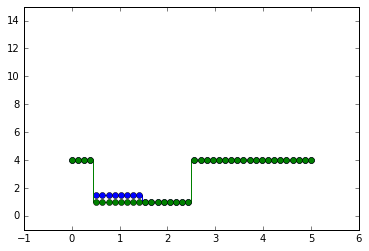

In [17]:
nx = 40
x = np.linspace(0,5,nx)
dx = np.diff(x)[0]

nt = 100
t = np.zeros((nt+1,))
cfl = 0.45

d0 = np.where(x<=2.5,0.0,3.0)#-0.1*(x**2-2.5**2))
d0 = np.where(x<=0.5,3.0,d0)+1.0

h0 = np.where(x<=1.5,1.5-d0,0.0)
h0 = np.where(h0<=0,0.0,h0)                 
u0 = np.zeros_like(h0)

plt.step(x,h0+d0,'o',where='mid')
plt.step(x,d0,'o',where='mid')
plt.xlim(-1,6)
plt.ylim(-1,15)

In [18]:
t,h,hu = nswe_wbmuscl2.sim_euler(h0,u0,d0,nt,nx,cfl,dx,nswe_wbmuscl2.bcs_open)

nswe_wbmuscl2.py:305: RuntimeWarning: invalid value encountered in divide
  u[n+1,:] = np.where(h[n+1,:]<=hmin,0.0,hu/h[n+1,:])


In [19]:
h.shape,x.shape

((100, 40), (40,))


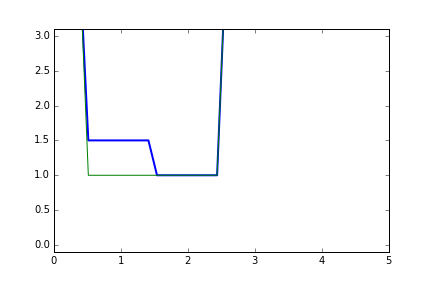
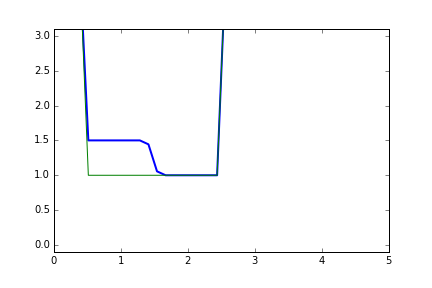
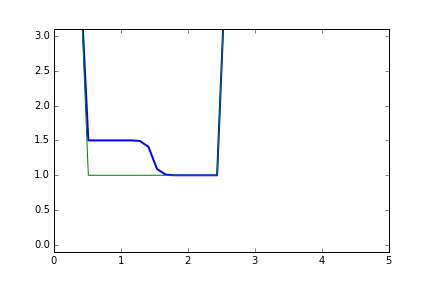
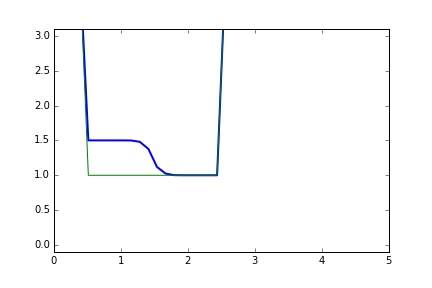
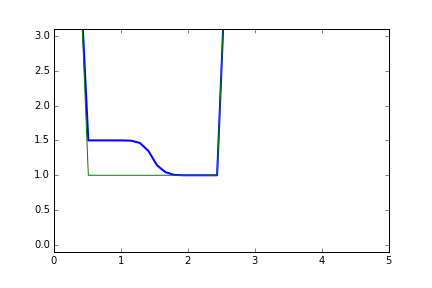
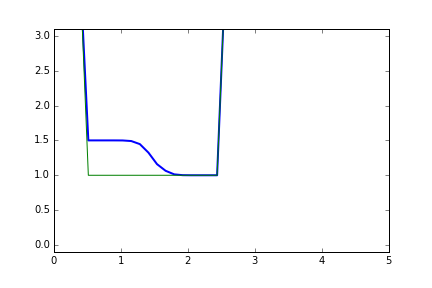
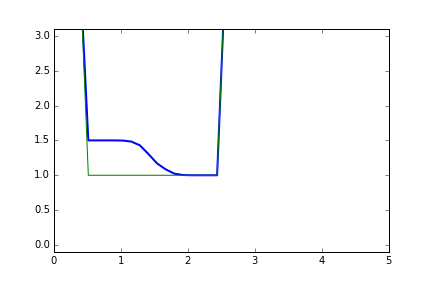
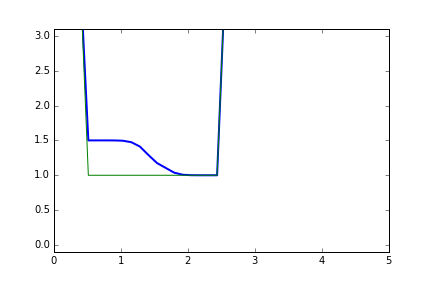
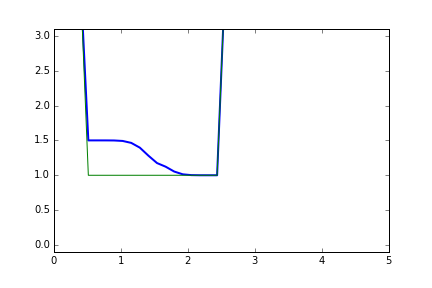
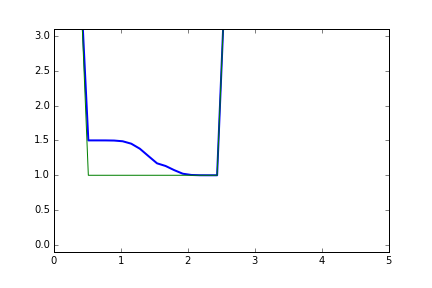
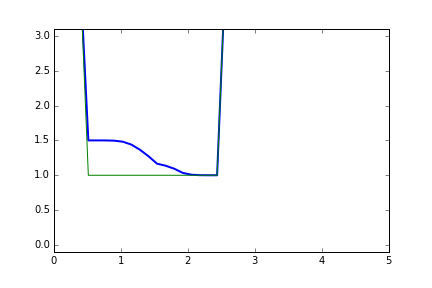
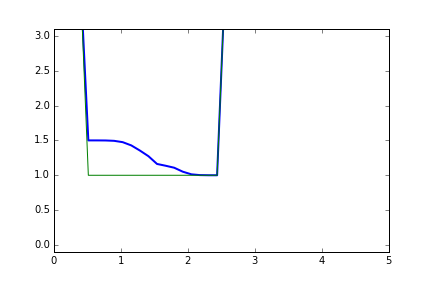
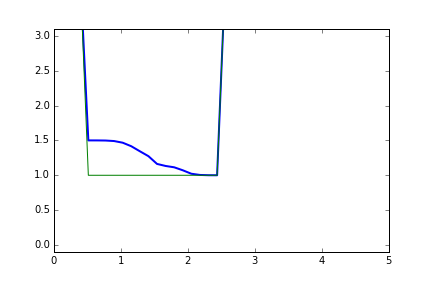
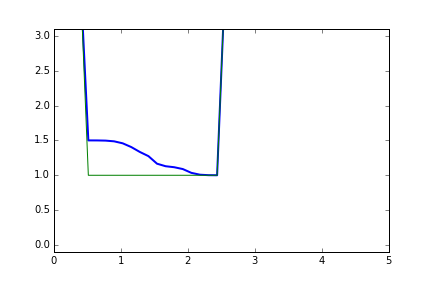
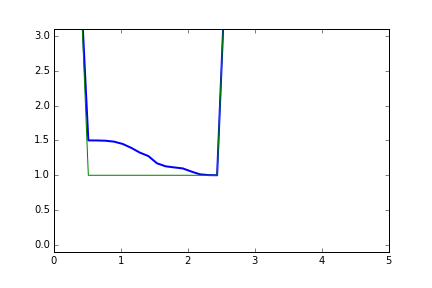
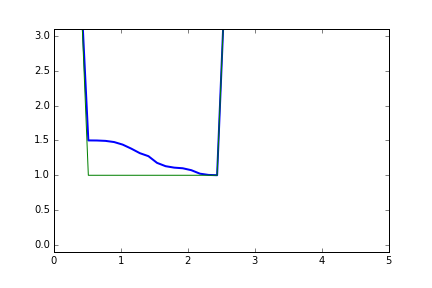
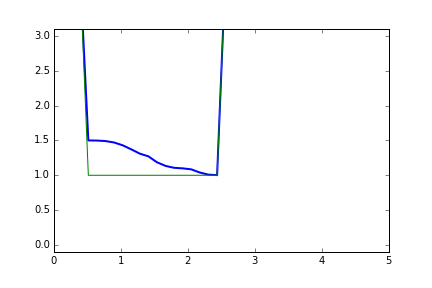
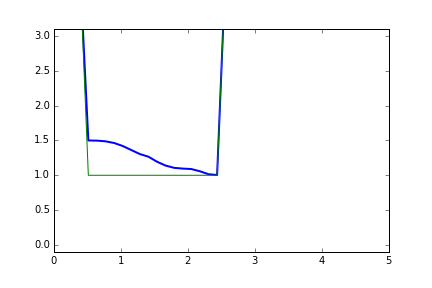
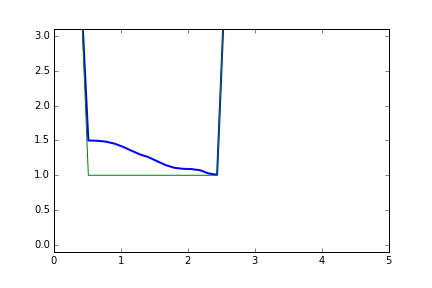
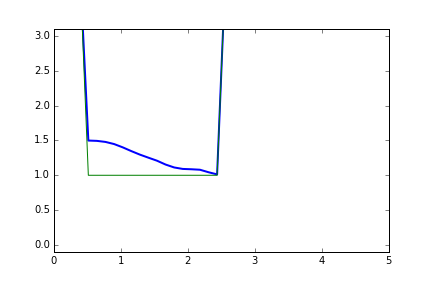
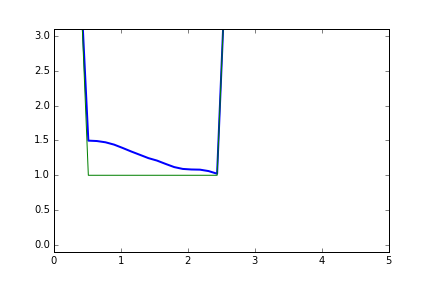
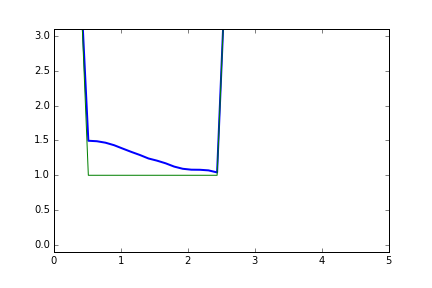
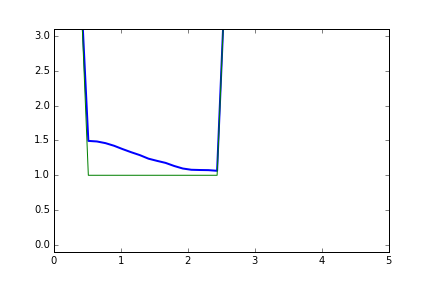
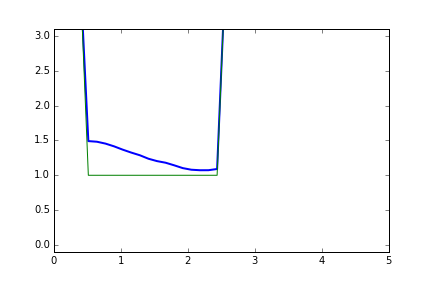
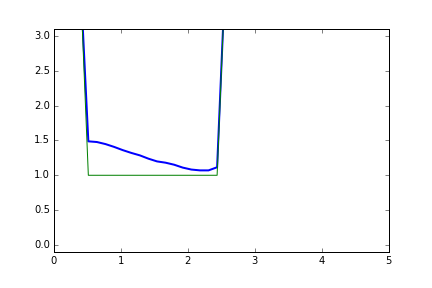
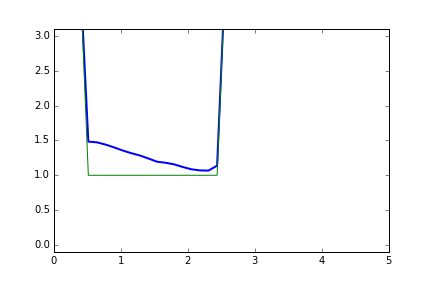
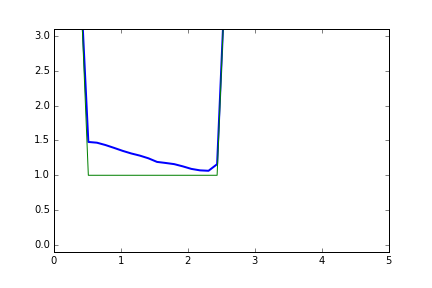
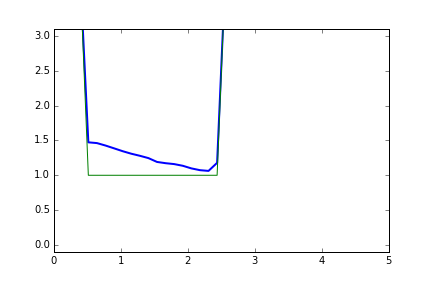
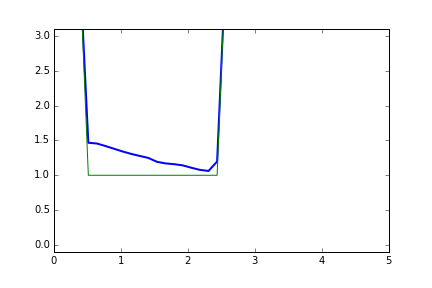
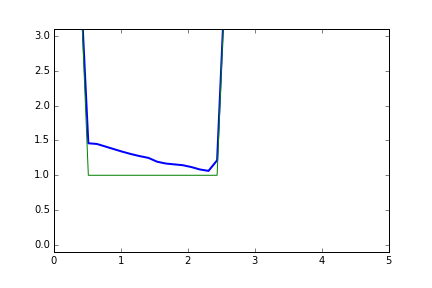
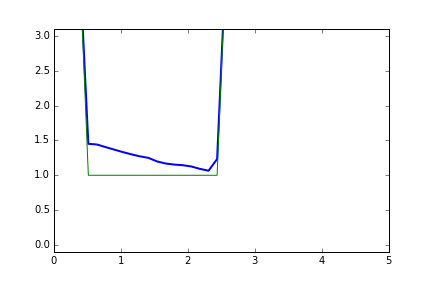
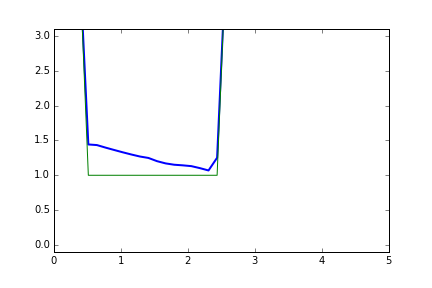
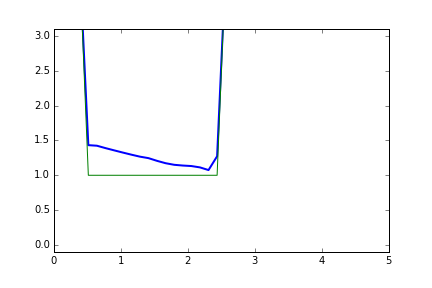
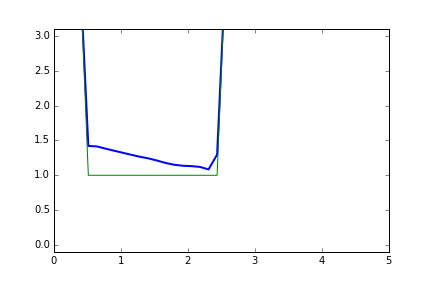
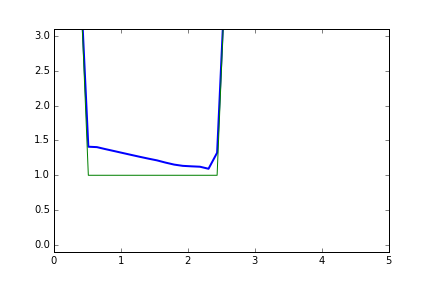
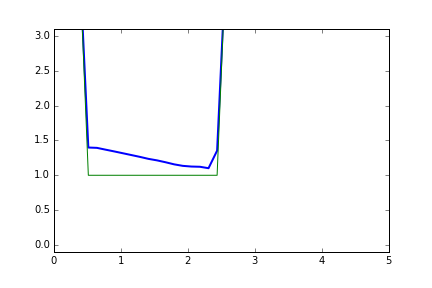
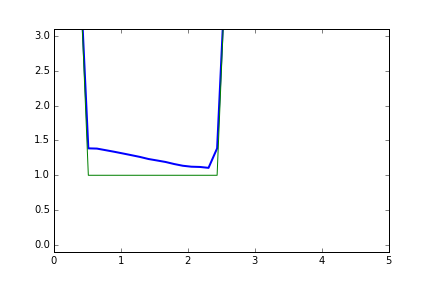
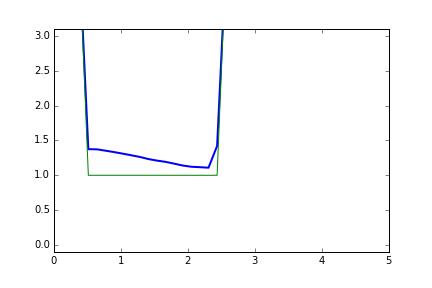
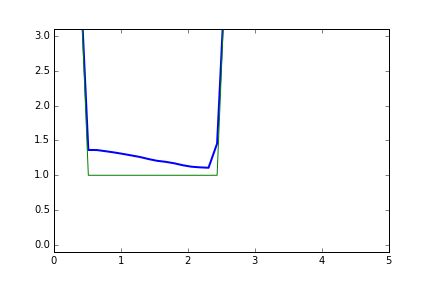
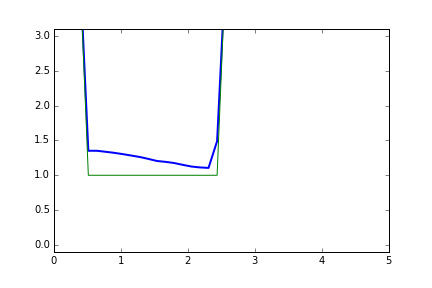
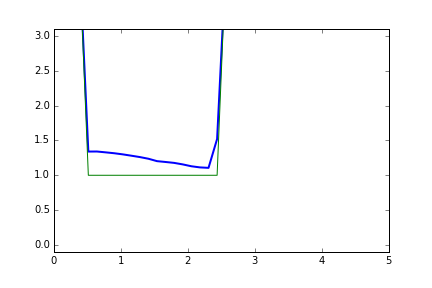
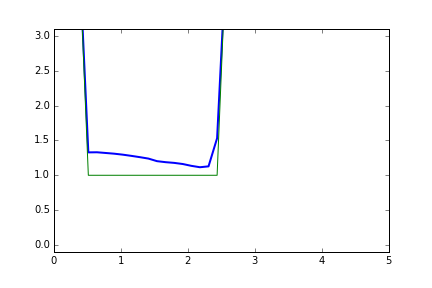
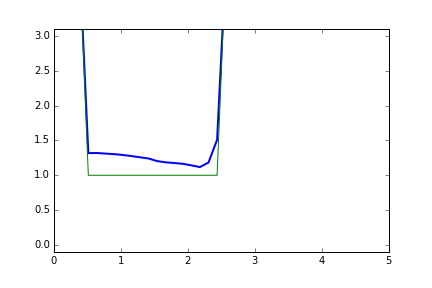
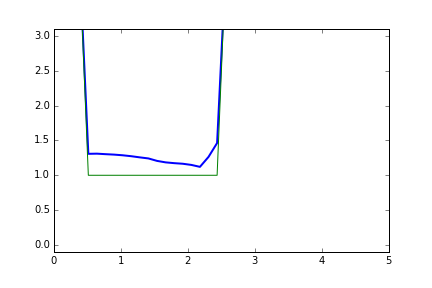
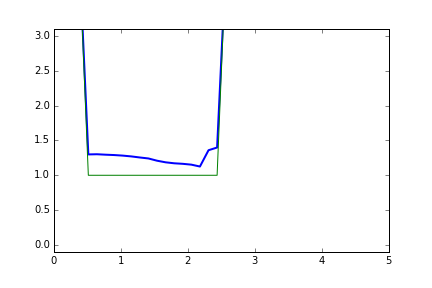
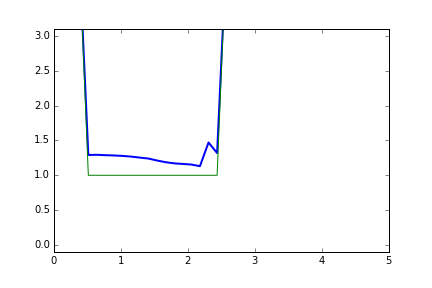
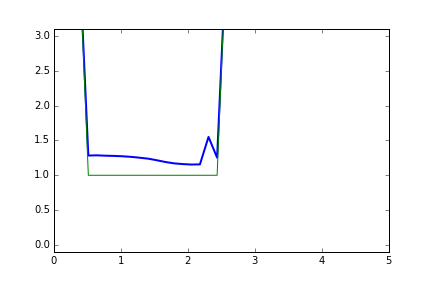
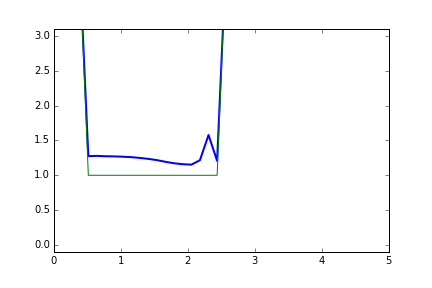
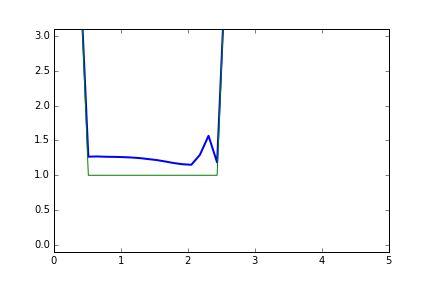
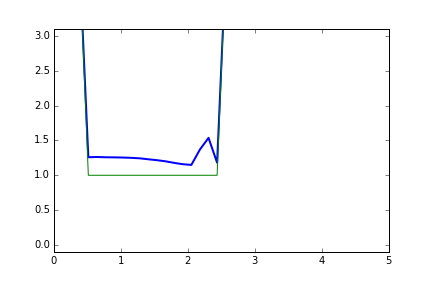
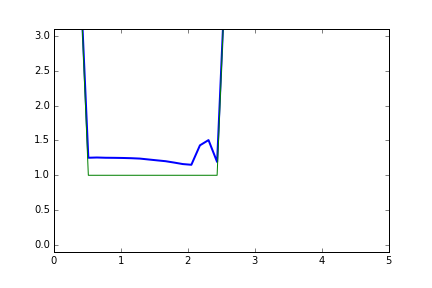
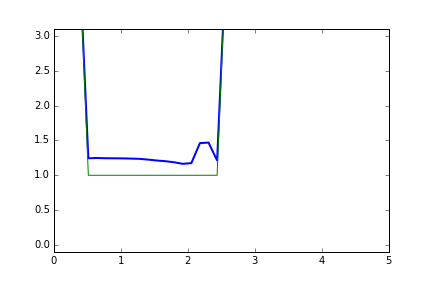
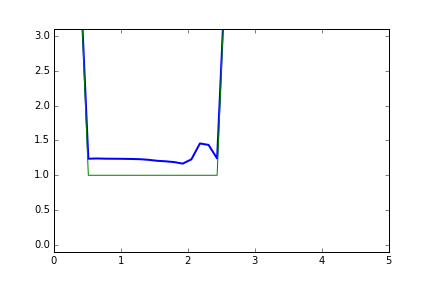
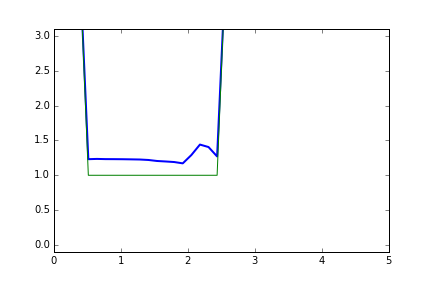
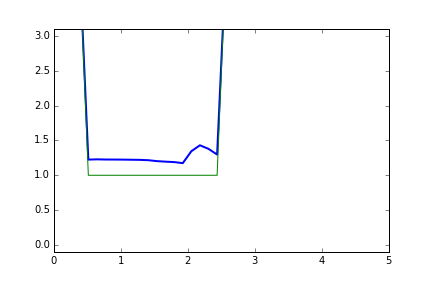
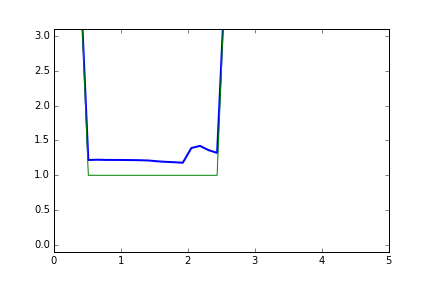
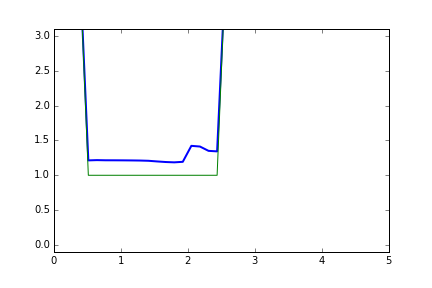
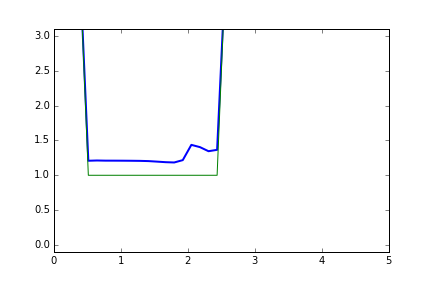
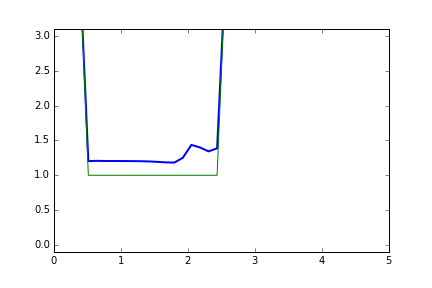
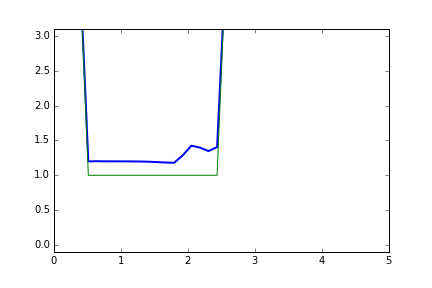
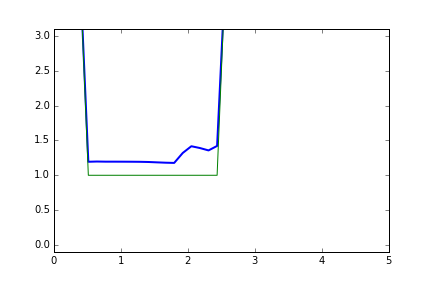
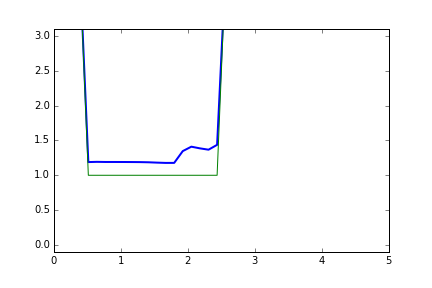
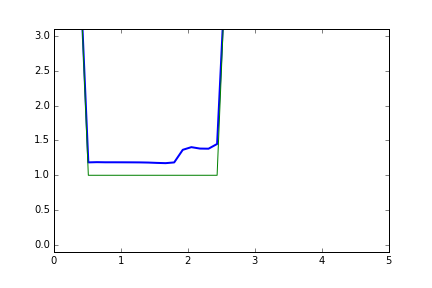
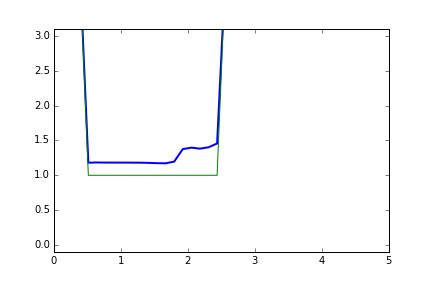
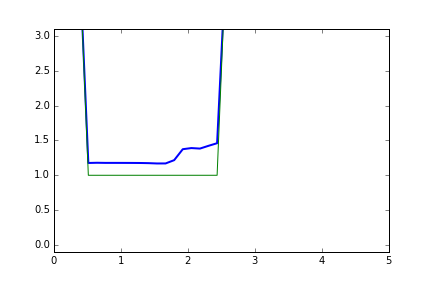
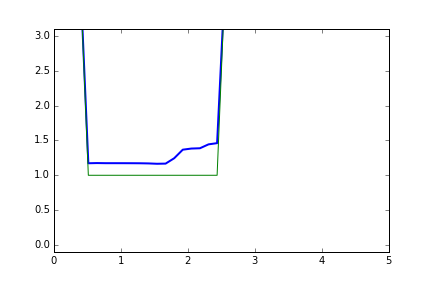
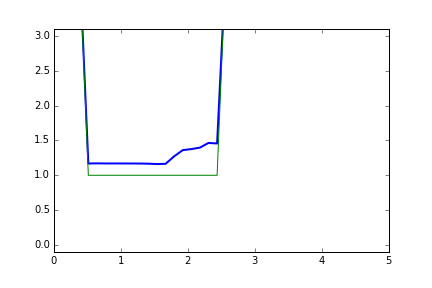
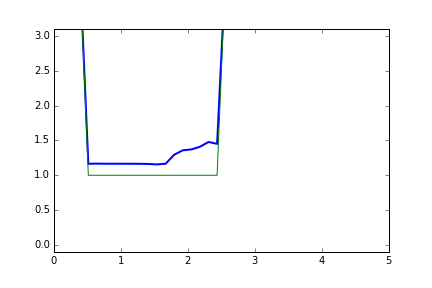
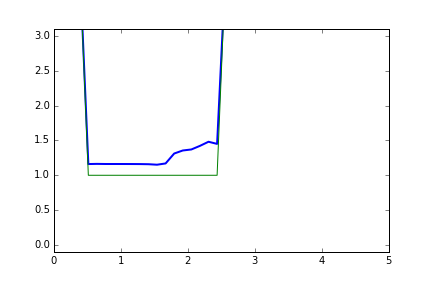
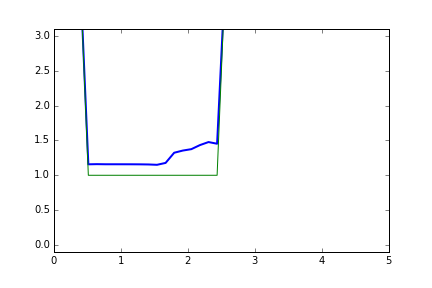
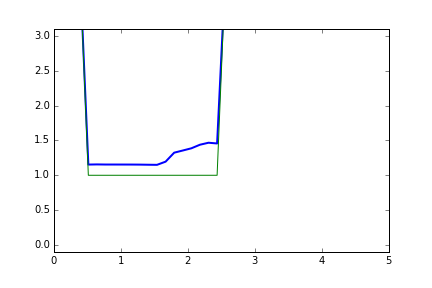
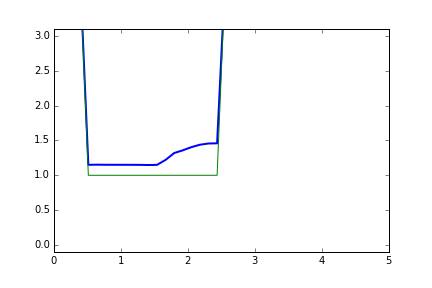
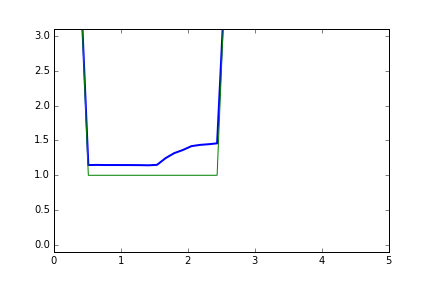
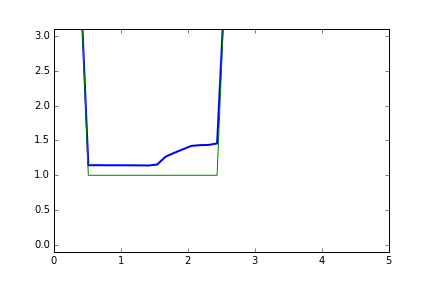
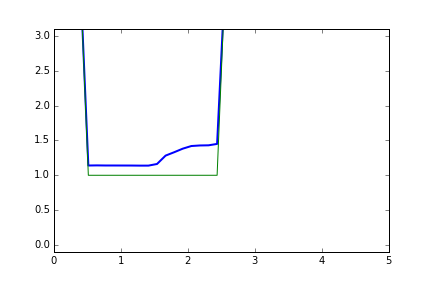
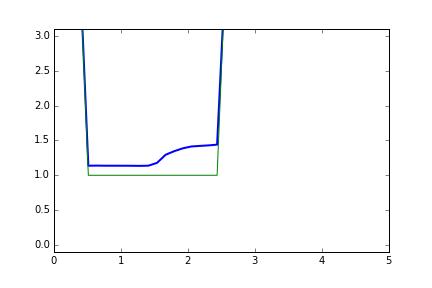
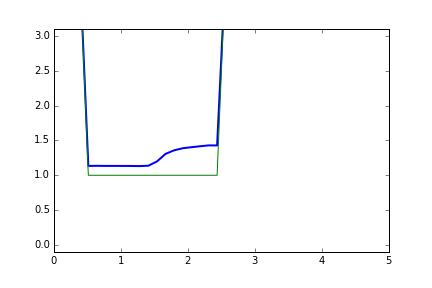
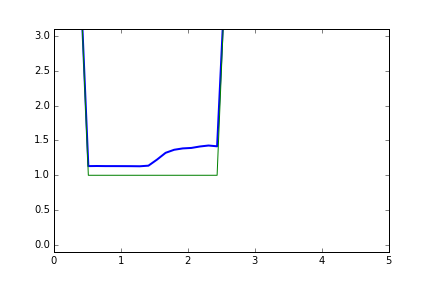
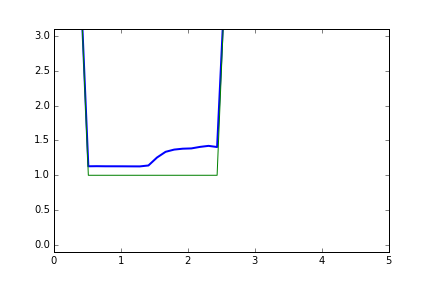
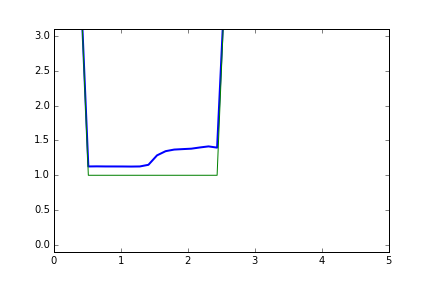
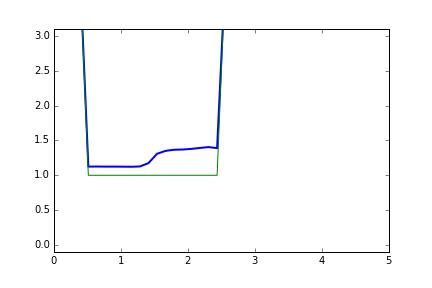
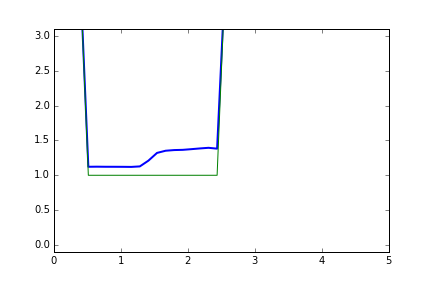
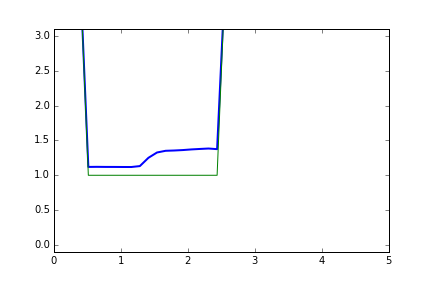
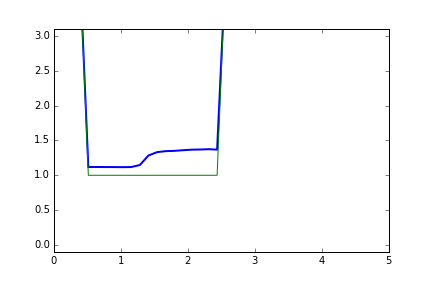
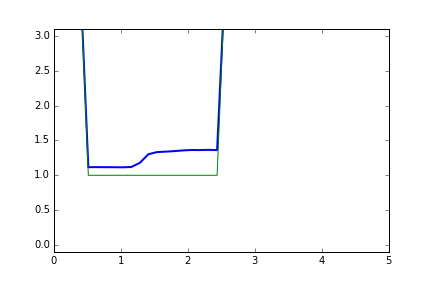
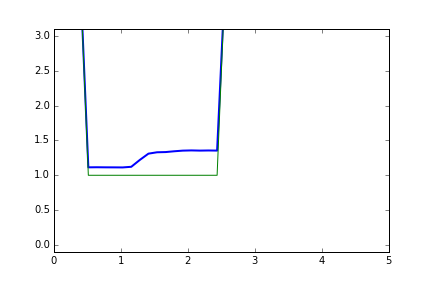
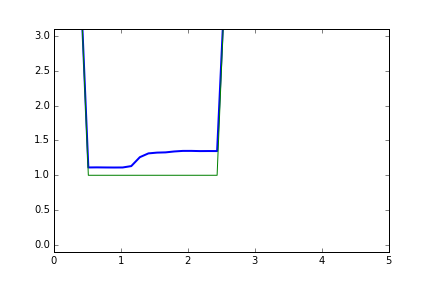
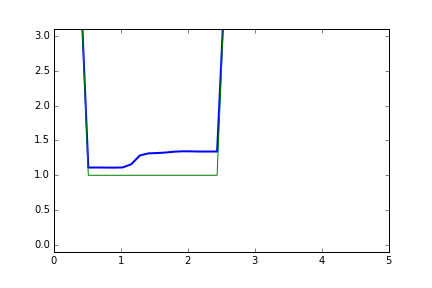
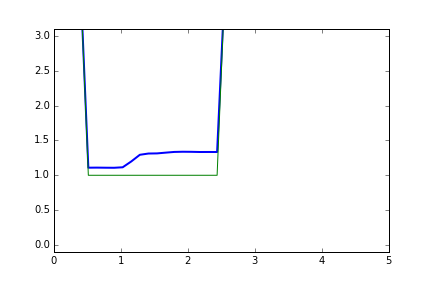
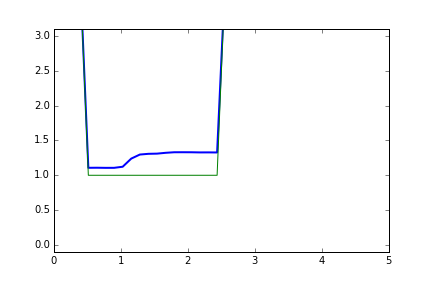
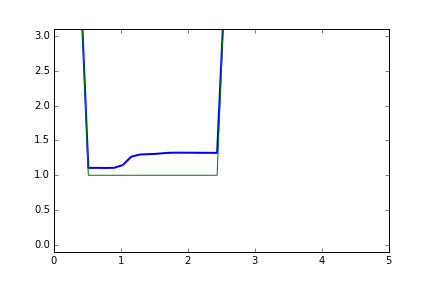
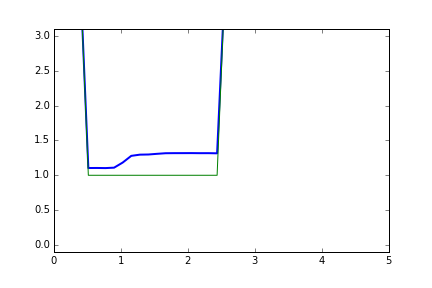
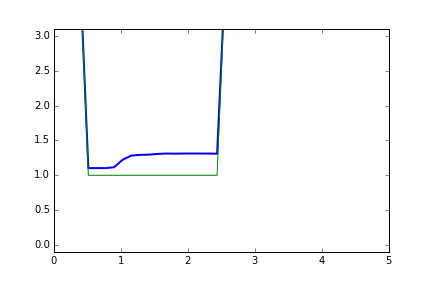
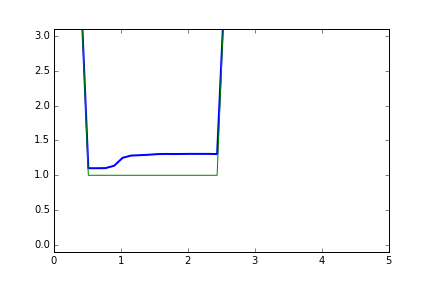
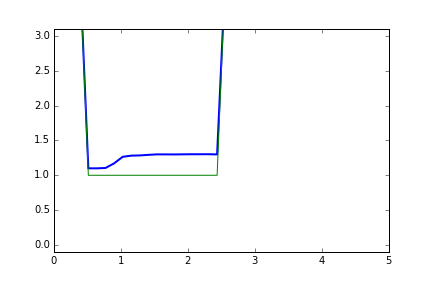
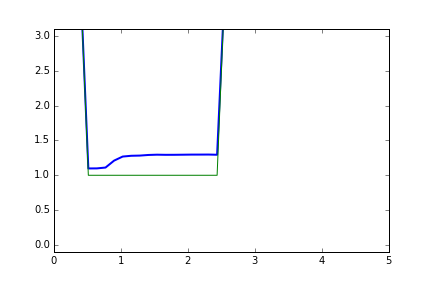
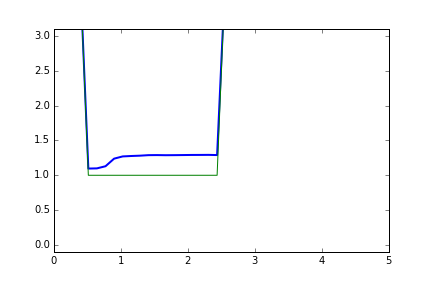
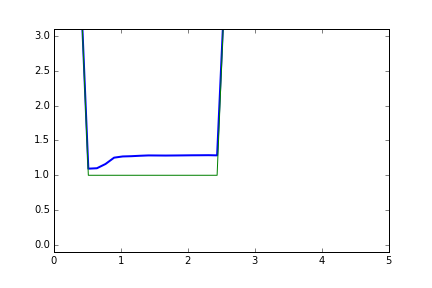
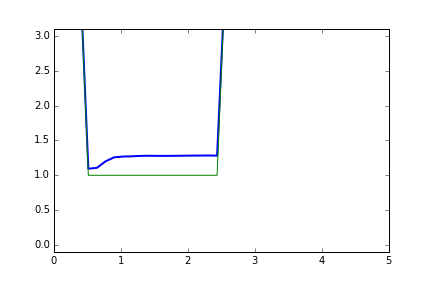

In [20]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(0, 5), ylim=(-0.1, 3.1))
line, = ax.plot([], [], lw=2)
ax.plot(x,d0)

def animate(i):
    line.set_data(x, h[i,:]+d0)
    return line,

animation.FuncAnimation(fig, animate, frames=nt-1, interval=45)

# RK 4

In [21]:
%%writefile nswe_wbmuscl2.py -a

def sim_rk4(h0,u0,d0,nt,nx,cfl,dx,bcs,bcargs=[],hmin=1e-10):    
    t = np.zeros(nt)
    h = np.zeros((nt,nx+4))
    u = np.zeros((nt,nx+4))
    h[0,2:-2] = h0
    u[0,2:-2] = u0
    d = np.zeros(nx+4)
    d[2:-2] = d0
    
    for n in range(nt-1):
        dt = setdt(h[n,:],u[n,:],dx,cfl)
        t[n+1] = t[n] + dt
        
        h1 = h[n,:]
        u1 = u[n,:]
        k1 = step(d,h1, u1, dx,nx,bcs,bcargs+[t[n],dt/2.],hmin)
        
        h2 = h[n,:]+0.5*dt*k1[0,:]
        u2 = np.where( h2>hmin, (h[n,:]*u[n,:]+0.5*k1[1,:]*dt)/h2, 0.0)
        k2 = step(d, h2, u2, dx, nx, bcs, bcargs+[t[n],dt/2.], hmin)
        
        h3 = h[n,:]+0.5*k2[0,:]*dt
        u3 = np.where(h3>hmin, (h[n,:]*u[n,:]+0.5*k2[1,:]*dt)/h3, 0.0)
        k3 = step(d, h3, u3, dx, nx, bcs, bcargs+[t[n],dt/2.], hmin)
        
        h4 = h[n,:]+k3[0,:]*dt
        u4 = np.where(h4>hmin, (h[n,:]*u[n,:]+k3[1,:]*dt)/h4, 0.0)
        k4 = step(d, h4, u4, dx, nx, bcs, bcargs+[t[n],dt/2.], hmin)
        
        h[n+1,:] = h[n,:] + dt/6.*(k1[0,:]+2.*k2[0,:]+2.*k3[0,:]+k4[0,:])
        hu = h[n,:]*u[n,:] + dt/6.*(k1[1,:]+2.*k2[1,:]+2.*k3[1,:]+k4[1,:])
        u[n+1,:] = np.where(h[n+1,:]>hmin, hu/h[n+1,:], 0.0)
    return t,h,u


Appending to nswe_wbmuscl2.py


In [22]:
!touch nswe_wbmuscl2.py
reload(nswe_wbmuscl2)
dir(nswe_wbmuscl2)

['__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 '__warningregistry__',
 'a',
 'allMusclReconstr',
 'bcs_cerrado',
 'bcs_open',
 'flux',
 'fluxes_sources',
 'g',
 'getHydrReconstr',
 'getMusclReconstr',
 'minmod',
 'musclReconstr',
 'np',
 'roe',
 'setdt',
 'sim_euler',
 'sim_rk4',
 'sources',
 'step']

In [23]:
t,h,hu = nswe_wbmuscl2.sim_rk4(h0,u0,d0,nt,nx,cfl,dx,nswe_wbmuscl2.bcs_open,hmin=1e-5)

nswe_wbmuscl2.py:325: RuntimeWarning: invalid value encountered in divide
nswe_wbmuscl2.py:329: RuntimeWarning: invalid value encountered in divide
nswe_wbmuscl2.py:333: RuntimeWarning: invalid value encountered in divide
nswe_wbmuscl2.py:338: RuntimeWarning: invalid value encountered in divide


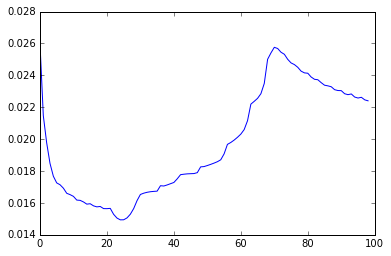

In [24]:
plt.plot(np.diff(t))


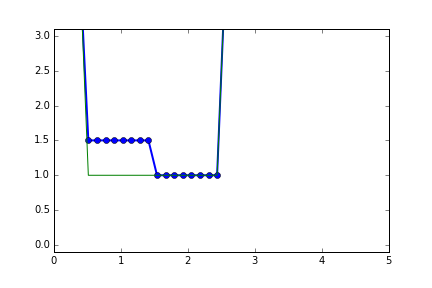
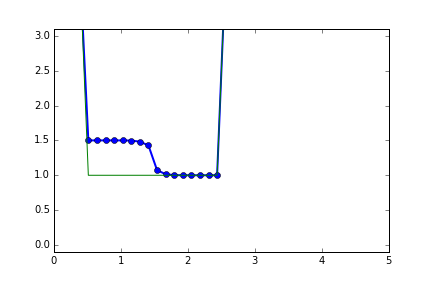
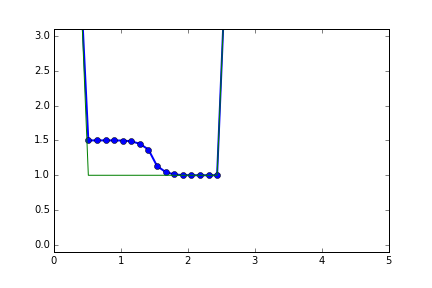
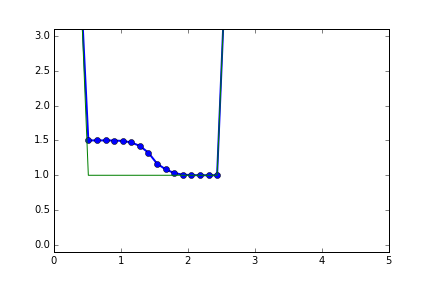
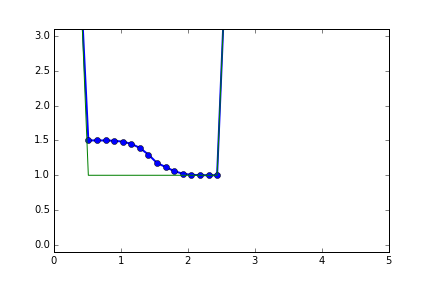
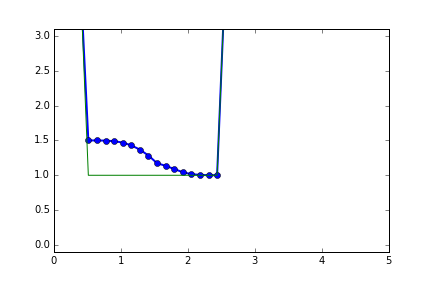
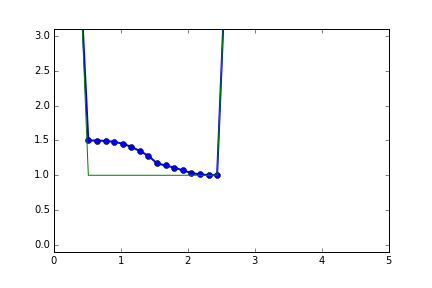
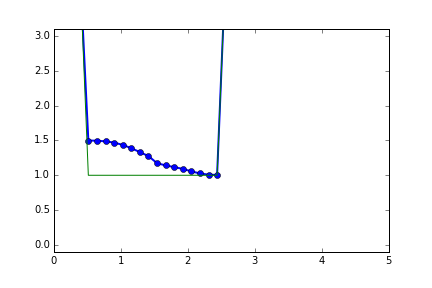
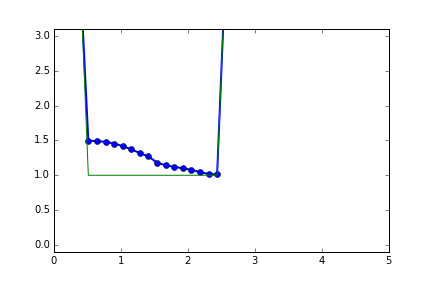
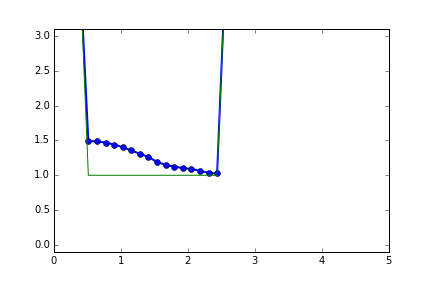
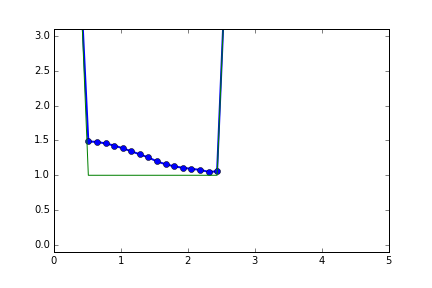
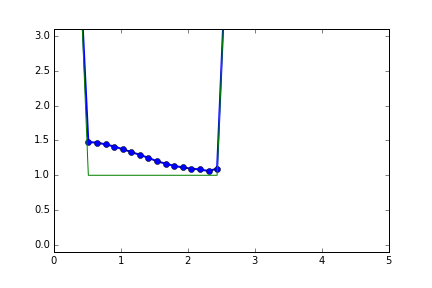
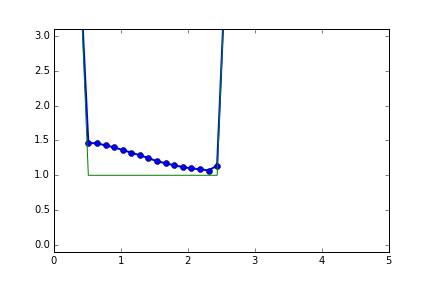
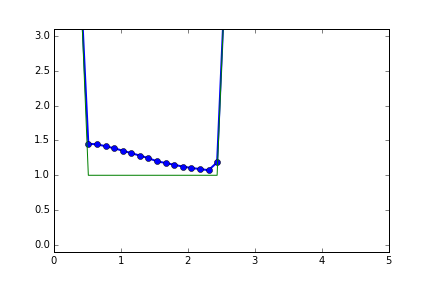
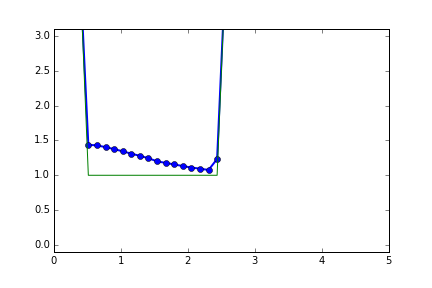
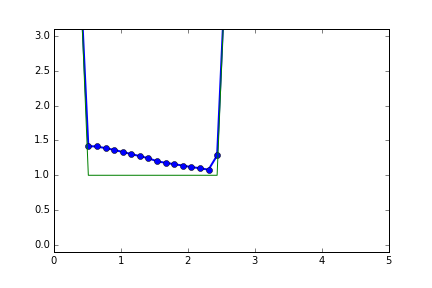
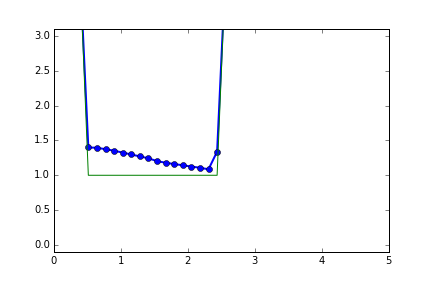
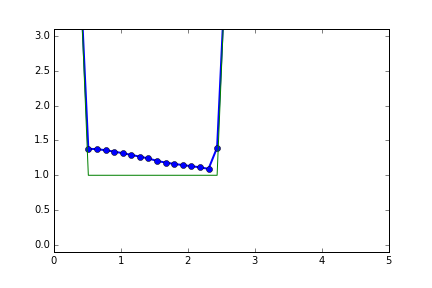
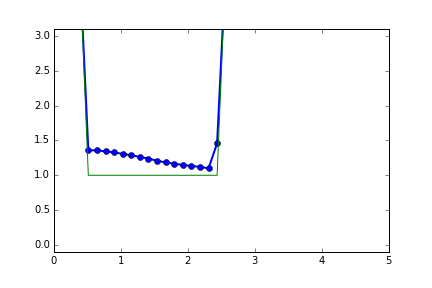
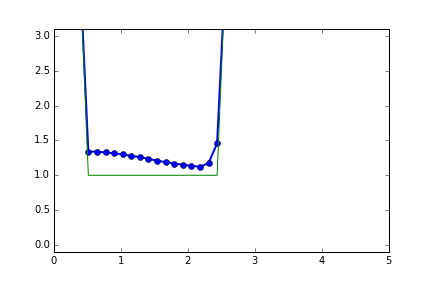
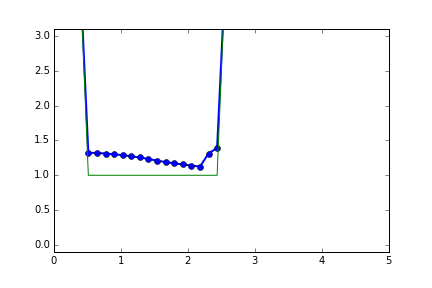
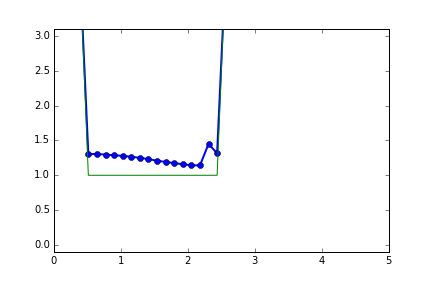
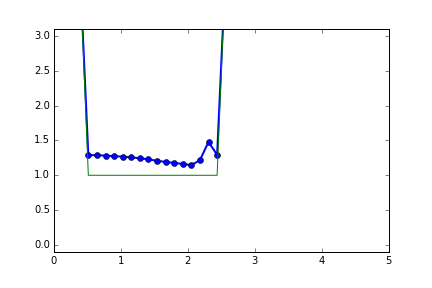
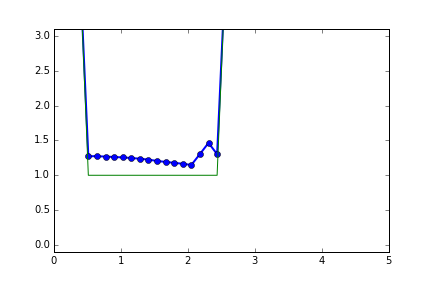
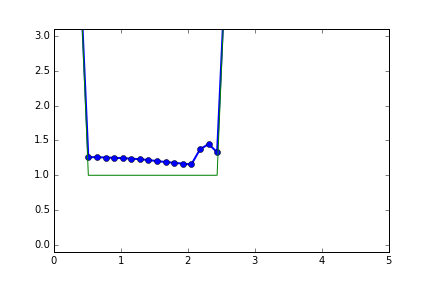
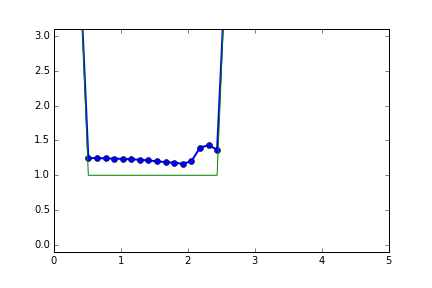
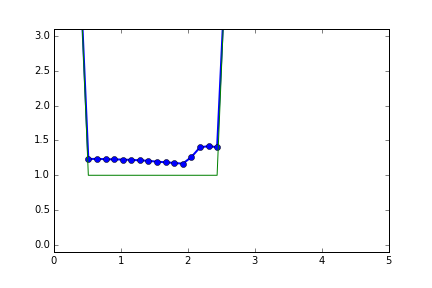
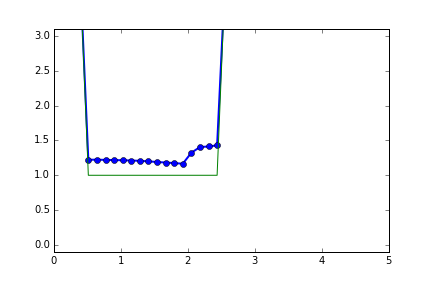
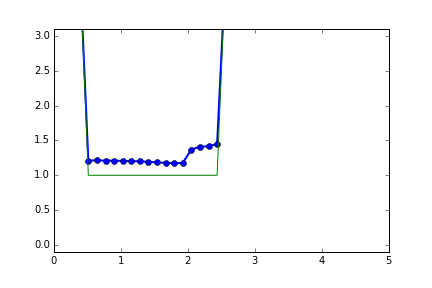
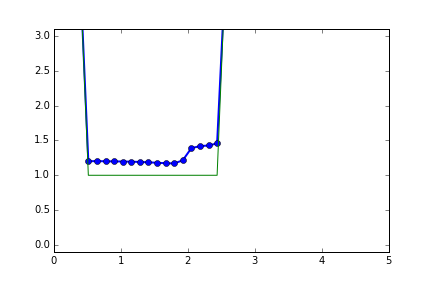
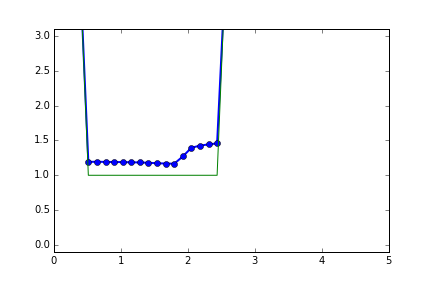
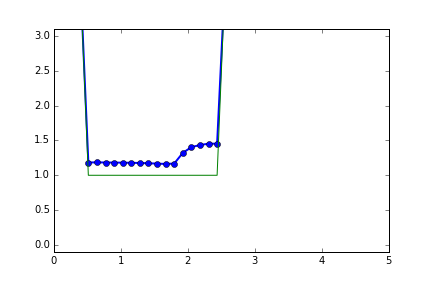
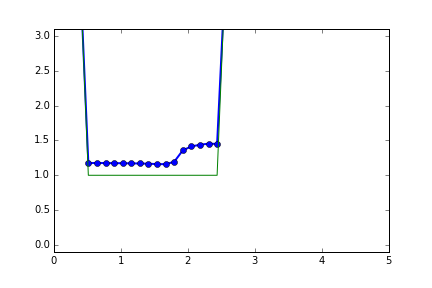
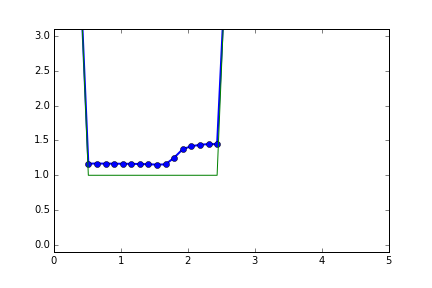
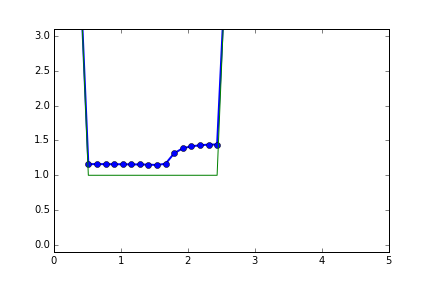
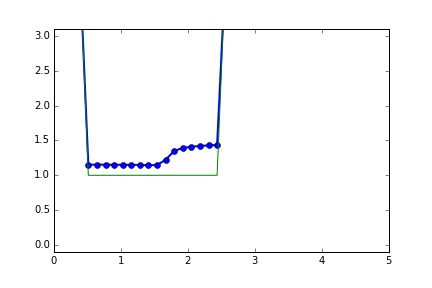
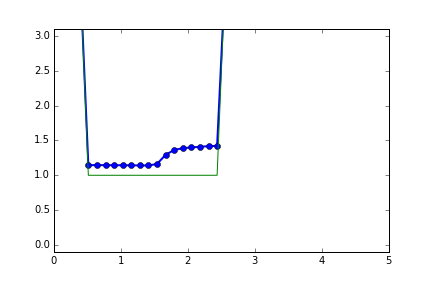
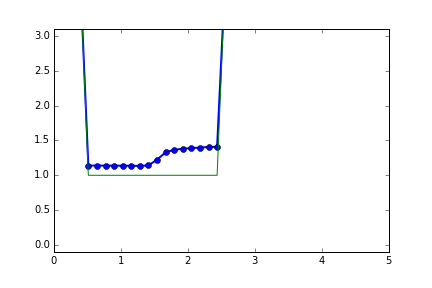
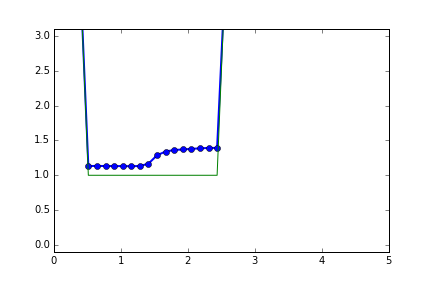
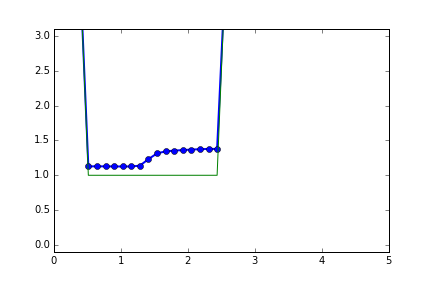
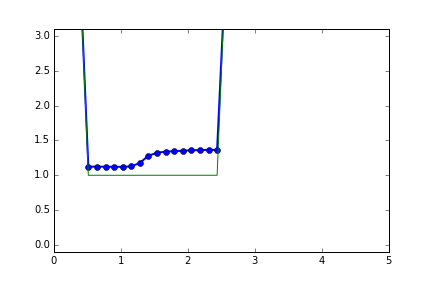
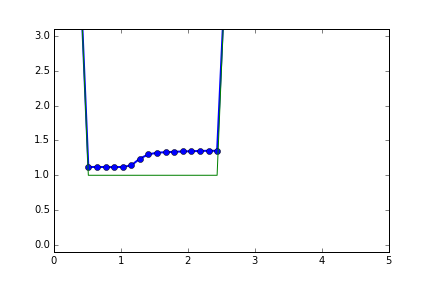
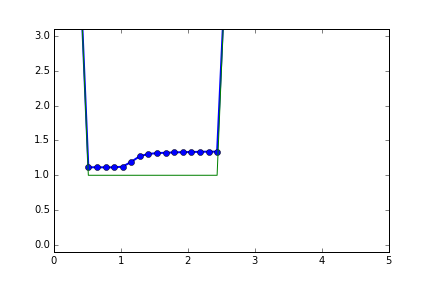
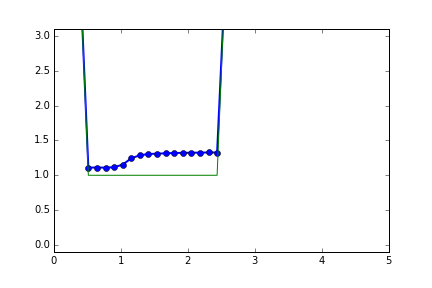
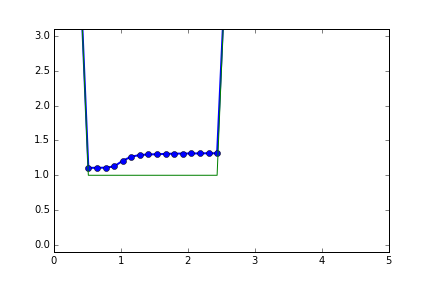
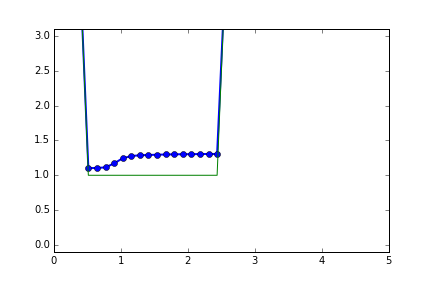
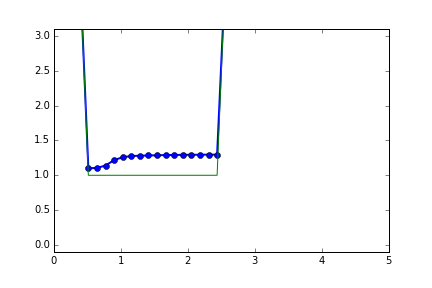
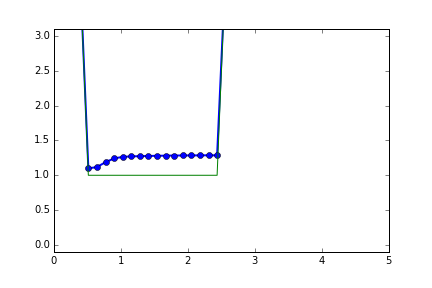
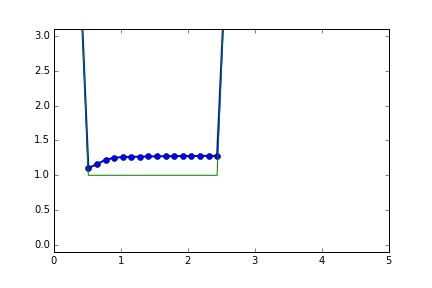
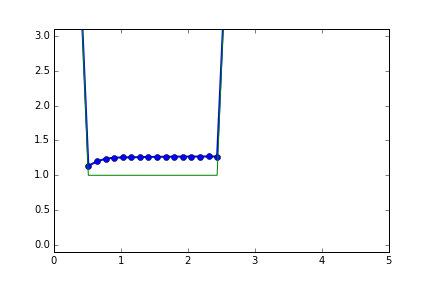

In [25]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 5), ylim=(-0.1, 3.1))
line, = ax.plot([], [], lw=2,marker='o')
ax.plot(x,d0)

def animate(i):
    i = min(2*i,nt-1)
    line.set_data(x, h[i,2:-2]+d0)
    return line,

animation.FuncAnimation(fig, animate, frames=nt/2, interval=200)